# Helper functions

## Read Token and API_KEY

In [1]:
from getpass import getpass

API_KEY = getpass("Trello API Key")
TOKEN = getpass("Trello Token")

Trello API Key ········
Trello Token ········


## Download cards and actions

In [2]:
import requests
import json

BOARD_ID = 'pfDnwT4D'

def api_call(endpoint, additional_params):
    params = {
        'key': API_KEY,
        'token': TOKEN,
        'limit': 1000,
    }
    params.update(additional_params)
    
    response = requests.get(
            f"https://api.trello.com/1{endpoint}",
            headers={ "Accept": "application/json" },
            params=params
    )

    if response.status_code == 200:
        return response.json()
    else:
        print(f"Request failed with status code {response.status_code}")
            
def get_cards(board_id):
    return api_call(f"/boards/{board_id}/cards", { 'filter': 'all' })
        
cards = get_cards(BOARD_ID)

print(f"Downloaded cards: {len(cards)}")

Downloaded cards: 228


In [3]:
def get_actions(card_id):
    return api_call(f"/cards/{card_id}/actions", { "filter": "updateCard:idList,copyCard,createCard,convertToCardFromCheckItem", })

for card in cards:
    card["actions"] = list(reversed(get_actions(card["id"])))

## Data validation

In [4]:
def is_move_action(action):
    return "listBefore" in action["data"] and "listAfter" in action["data"]

for card in cards:
    card["actions"] = [action for (index, action) in enumerate(card["actions"]) if (action["type"] != "updateCard" and index == 0) or is_move_action(action)]

In [5]:
def is_valid_card(card):
    return len(card["actions"]) > 0 and is_first_action_copy_or_create(card) and is_tail_of_actions_move_actions(card)

def is_first_action_copy_or_create(card):
    return card["actions"][0]["type"] in ["createCard", "copyCard", "convertToCardFromCheckItem"]

def is_tail_of_actions_move_actions(card):
    return all(is_move_action(action) for action in card["actions"][1:])

valid_cards = [card for card in cards if is_valid_card(card)]
invalid_cards = [card for card in cards if not is_valid_card(card)]

print(f"Invalid cards: {len(invalid_cards)}")

for card in invalid_cards:
    print(card["name"])
    prettyprint(card["actions"])

Invalid cards: 0


## Download lists

In [6]:
def get_lists(board_id):
    return api_call(f"/boards/{board_id}/lists", {})

lists = get_lists(BOARD_ID)

In [7]:
list_id2list_name = dict((l["id"], l["name"]) for l in lists)
list_id2list_name

{'63bc34d346143f025ffe3152': 'Backlog',
 '6374b6c8d908a5001de2fa7b': 'Priorisierung',
 '6374b6c8d908a5001de2fa7c': 'Entwicklung',
 '6374b70b76ae9a0265bb679b': 'Feedback / Blocked',
 '6374b723ad21d7062366f9b6': 'Testen',
 '641838c6ee62b9f7a7fa8ac2': 'Erledigt (aber noch nicht veröffentlicht)',
 '6374b72bcbb33c0681d4b99b': 'Veröffentlicht (kann genutzt werden)'}

In [8]:
list_name2list_id = dict((l["name"], l["id"]) for l in lists)
list_name2list_id

{'Backlog': '63bc34d346143f025ffe3152',
 'Priorisierung': '6374b6c8d908a5001de2fa7b',
 'Entwicklung': '6374b6c8d908a5001de2fa7c',
 'Feedback / Blocked': '6374b70b76ae9a0265bb679b',
 'Testen': '6374b723ad21d7062366f9b6',
 'Erledigt (aber noch nicht veröffentlicht)': '641838c6ee62b9f7a7fa8ac2',
 'Veröffentlicht (kann genutzt werden)': '6374b72bcbb33c0681d4b99b'}

## Get finished cards

In [9]:
def get_last_move_date(card):
    dates = [a["date"] for a in card["actions"] if is_move_action(a) or a["type"] in ["createCard", "copyCard"]]
             
    return max(dates)

get_last_move_date(cards[200])

'2023-02-13T07:55:33.477Z'

In [10]:
finished_cards = [card for card in cards if card["idList"] == list_name2list_id["Veröffentlicht (kann genutzt werden)"]]

print(f"Finished cards: {len(finished_cards)}")

Finished cards: 77


# Print card nicely

In [73]:
import pandas as pd

from datetime import timezone, datetime

def get_time_in_lists(card):
    result = dict((l["id"], pd.Timedelta(0)) for l in lists)
    
    last_time = pd.to_datetime(card["actions"][0]["date"]) 
    
    for action in card["actions"][1:]:
        diff = pd.to_datetime(action["date"]) - last_time
        
        if action["data"]["listBefore"]["id"] in result:
            result[action["data"]["listBefore"]["id"]] += diff
        
        last_time = pd.to_datetime(action["date"])
    
    result[card["idList"]] += pd.to_datetime(datetime.now(timezone.utc))-last_time
    
    return result

get_time_in_lists(cards[200])

{'63bc34d346143f025ffe3152': Timedelta('0 days 00:00:00'),
 '6374b6c8d908a5001de2fa7b': Timedelta('0 days 00:00:00'),
 '6374b6c8d908a5001de2fa7c': Timedelta('2 days 04:47:08.697000'),
 '6374b70b76ae9a0265bb679b': Timedelta('4 days 15:25:13.209000'),
 '6374b723ad21d7062366f9b6': Timedelta('0 days 00:00:00'),
 '641838c6ee62b9f7a7fa8ac2': Timedelta('0 days 00:00:00'),
 '6374b72bcbb33c0681d4b99b': Timedelta('167 days 08:30:31.317562')}

In [74]:
from IPython.display import display, HTML

def print_card(card):
    html = '<div style="padding: 1em; border: 3px black solid; border-radius: 1em; background: #f2f2f2">'
    
    if len(card["labels"]) > 0:
        html += '<div>'
        for label in card["labels"]:
            html += f'<span style="display: inline-block; border: 1px black solid; padding: 0.25em; border-radius: 0.125em; margin-right: 1em; background: #e0e0e0">{label["name"]}</span>'
        html += '</div>'
    
    html += f'<h3><a href="{card["url"]}">{card["name"]}</a></h3>'
    
    time_in_lists = get_time_in_lists(card)
    
    html += "<ul>"
    for list_name in ["Entwicklung", "Feedback / Blocked", "Testen"]:
        t = prettyprint_timedelta(time_in_lists[list_name2list_id[list_name]])
        html += f'<li>{list_name}: {t}</li>'
    
    t = prettyprint_timedelta(time_in_lists[list_name2list_id["Entwicklung"]] + time_in_lists[list_name2list_id["Testen"]])
    html += f'<li><b>Enticklung + Testen: {t}</b></li>'
    
    t = prettyprint_timedelta(time_in_lists[list_name2list_id["Entwicklung"]] + time_in_lists[list_name2list_id["Testen"]] + time_in_lists[list_name2list_id["Feedback / Blocked"]])
    html += f'<li>Gesamt: {t}</li>'
    html += "</ul>"
    
    html += '</div>'
    
    display(HTML(html))
    
def prettyprint_timedelta(timedelta_value):
    return f"{timedelta_value.days} days, {timedelta_value.seconds // 3600} hours, {timedelta_value.seconds // 60 % 60} minutes, {timedelta_value.seconds % 60} seconds"
    
print_card(cards[146])

# Count of finished cards per month

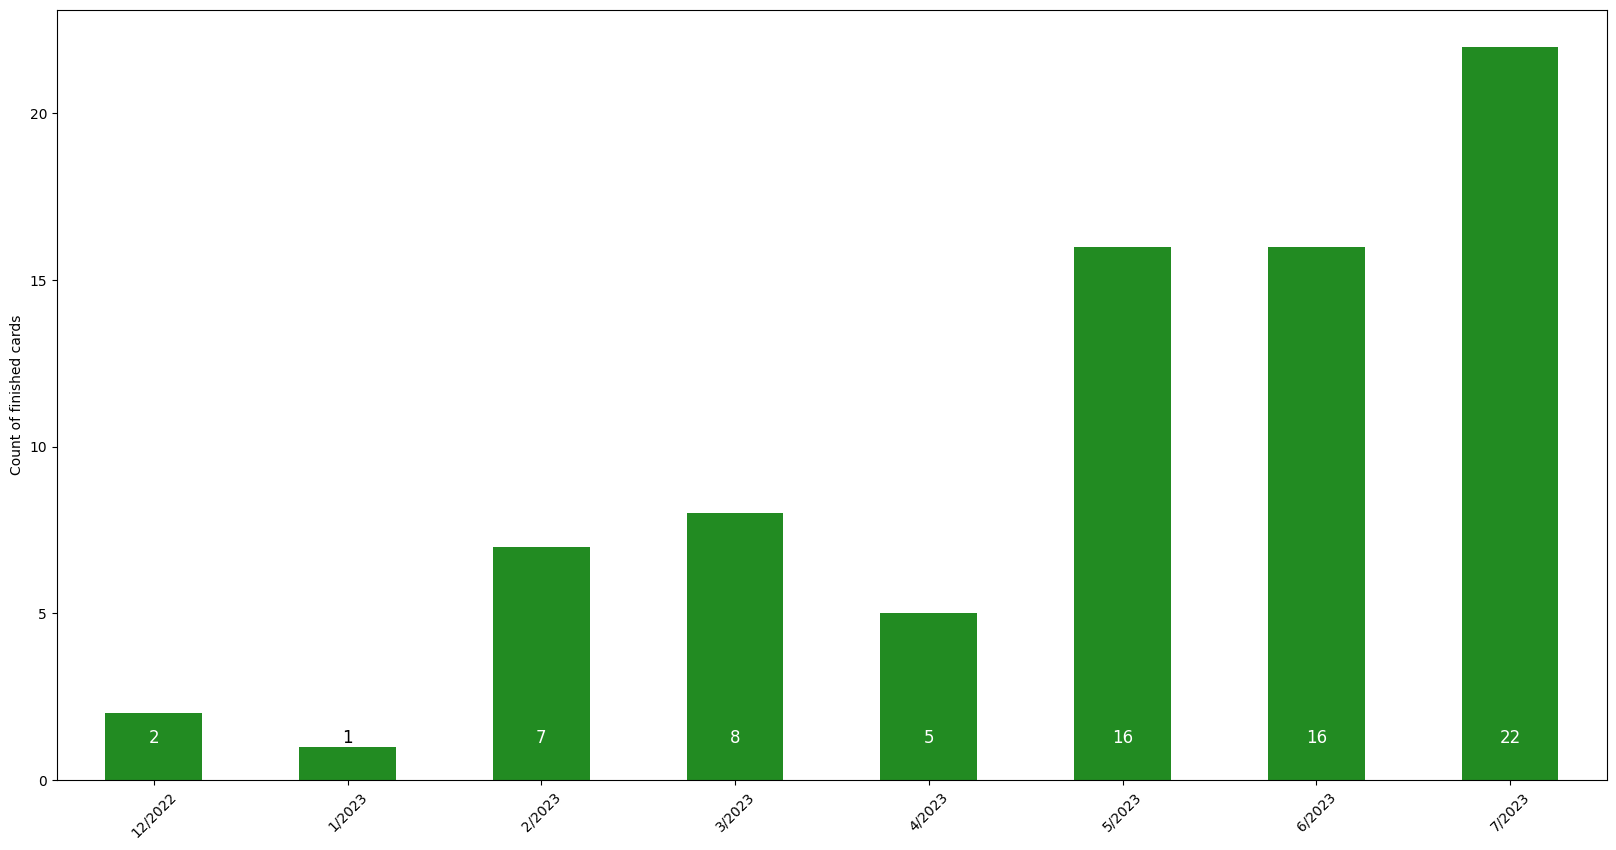

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

def plot(resample_time="1M", score_per_card= lambda x: 1, title="Count of finished cards"):
    data = dict((get_last_move_date(card), score_per_card(card)) for card in finished_cards)
    df = pd.DataFrame.from_dict(data, orient='index', columns=['Finished Cards'])
    df.index = pd.to_datetime(df.index)
    df.head()
    
    df = df.resample(resample_time).sum()
    ax = df.plot(figsize=(20,10), kind="bar", legend=False, color='forestgreen')
    plt.ylabel(title)
    
    for index, row in enumerate(df["Finished Cards"]):
        ax.text(index, 1, str(int(row)), ha='center', va='bottom', fontsize="large", color="black" if row < 2 else "white")
    
    plt.xticks(range(len(df.index)), [f"{d.month}/{d.year}" for d in df.index], rotation=45)
    plt.show()
    
plot(resample_time="1M")

# Total count of completed cards within the last 30 days

The chart illustrates the daily count of completed cards over the past 30 days.

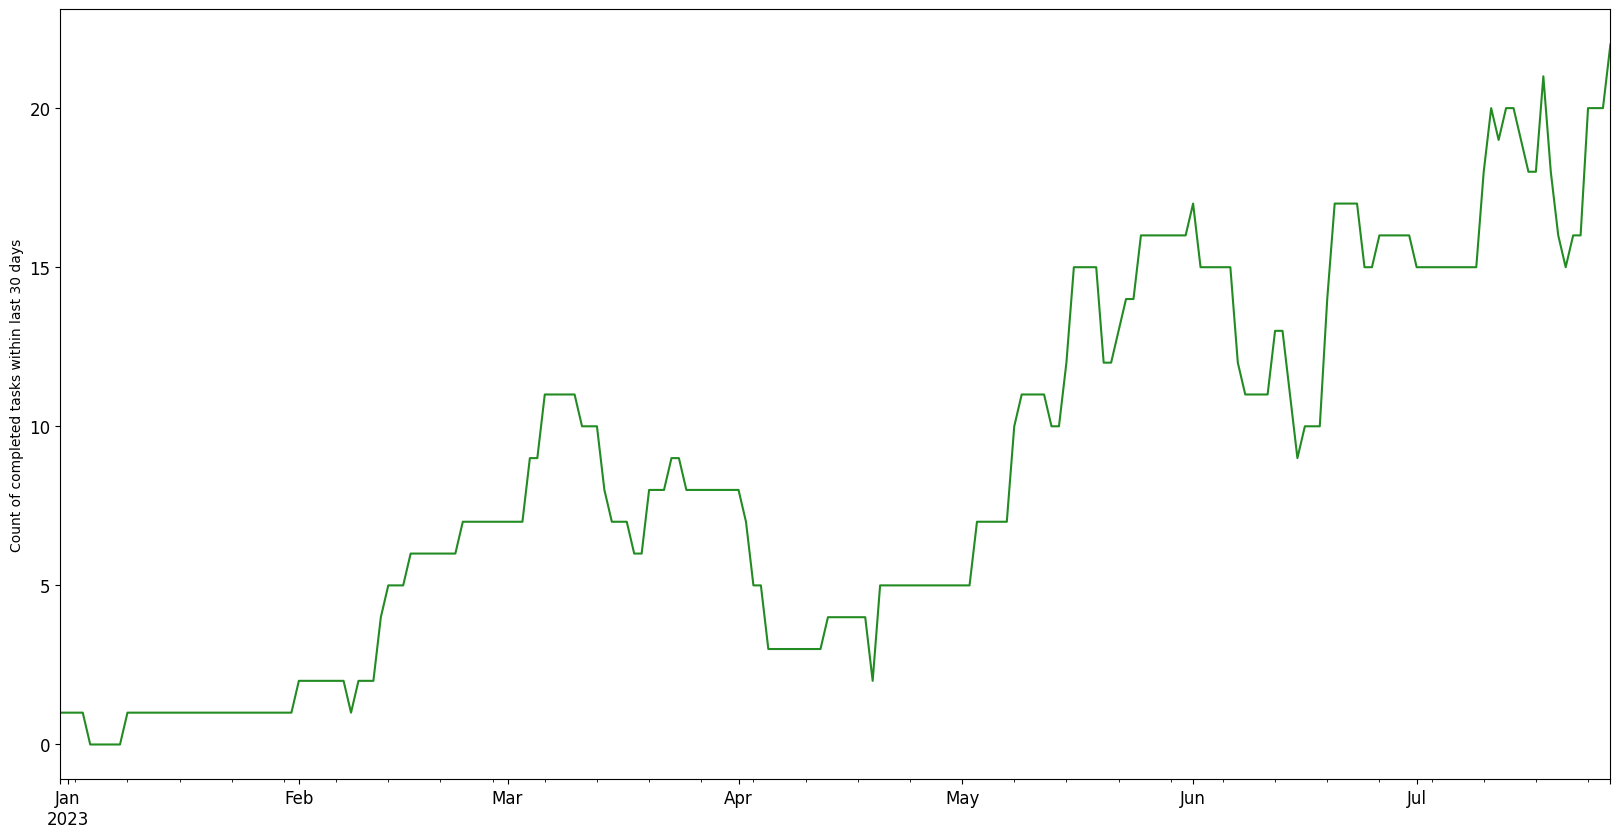

In [89]:
def plot_rolling(days=30, score_per_card= lambda x: 1, title="Count of completed tasks within last 30 days"):
    data = dict((get_last_move_date(card), score_per_card(card)) for card in finished_cards)
    df = pd.DataFrame.from_dict(data, orient='index', columns=['Finished Cards'])
    df.index = pd.to_datetime(df.index)
    df.head()
    
    df = df.resample("1D").sum().rolling(window=days, min_periods=days).sum()
    df = df[days:]
    df.plot(figsize=(20,10), legend=False, color="forestgreen", fontsize="large")
    plt.ylabel(title)
    plt.show()

plot_rolling()

# Total count of completed cards within the last 90 days

The chart illustrates the daily count of completed cards over the past 90 days.

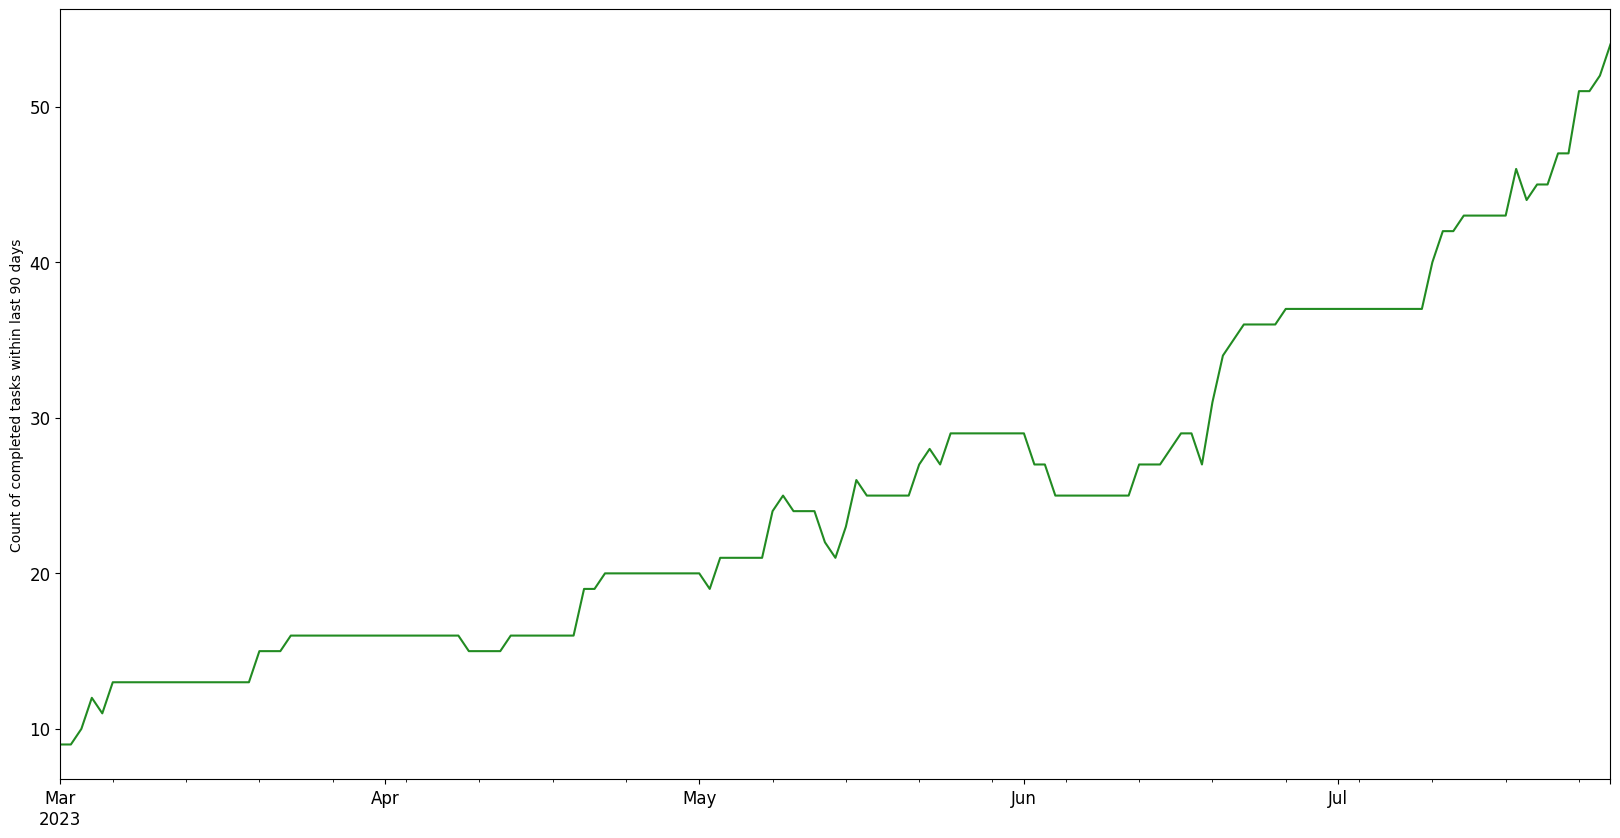

In [51]:
plot_rolling(days=90, title="Count of completed tasks within last 90 days")

# Completed tasks weighted by number of estimated days beforehand (best case scenario)

We add to our cards labels which represent roughly the size of this task.
We can attribute the number of total work days needed to finish this task in a best case scenario (when everything goes with plan and there aren't any unexpected blockers – will be rarely the case):

* Mini-Feature = 0.5 (day)
* Bug = 2.5 (days)
* Size `S` = 2.5 (days)
* Size `M` = 10 (days)
* Size `L` = 40 (days)

When we add for all cards the number of those days we get the number of estimated days in a best case scenario for those cards. With ~10 FTE in development and ~22 workdays per month we expect to get cards with a sum of ~220 done. 

In [81]:
def get_score(card, default=None):
    for label in card["labels"]:
        if label["name"] == "Mini-Feature":
            return 0.5
        elif label["name"] == "S":
            return 2.5
        elif label["name"] == "M":
            return 10
        elif label["name"] == "L":
            return 40
        elif label["name"] == "Bug":
            return 2.5
    return default

all_scores = [get_score(card) for card in cards]
actual_scores = [s for s in all_scores if s != None]
mean_score = sum(actual_scores) / len(actual_scores)

print(f"Mean of estimated days per card (best case scenario): {mean_score}")

Mean of estimated days per card (best case scenario): 5.8798076923076925


## Plot of this number per month

The following diagram shows this number per month. All cards without a size label get the computed mean value as weight.

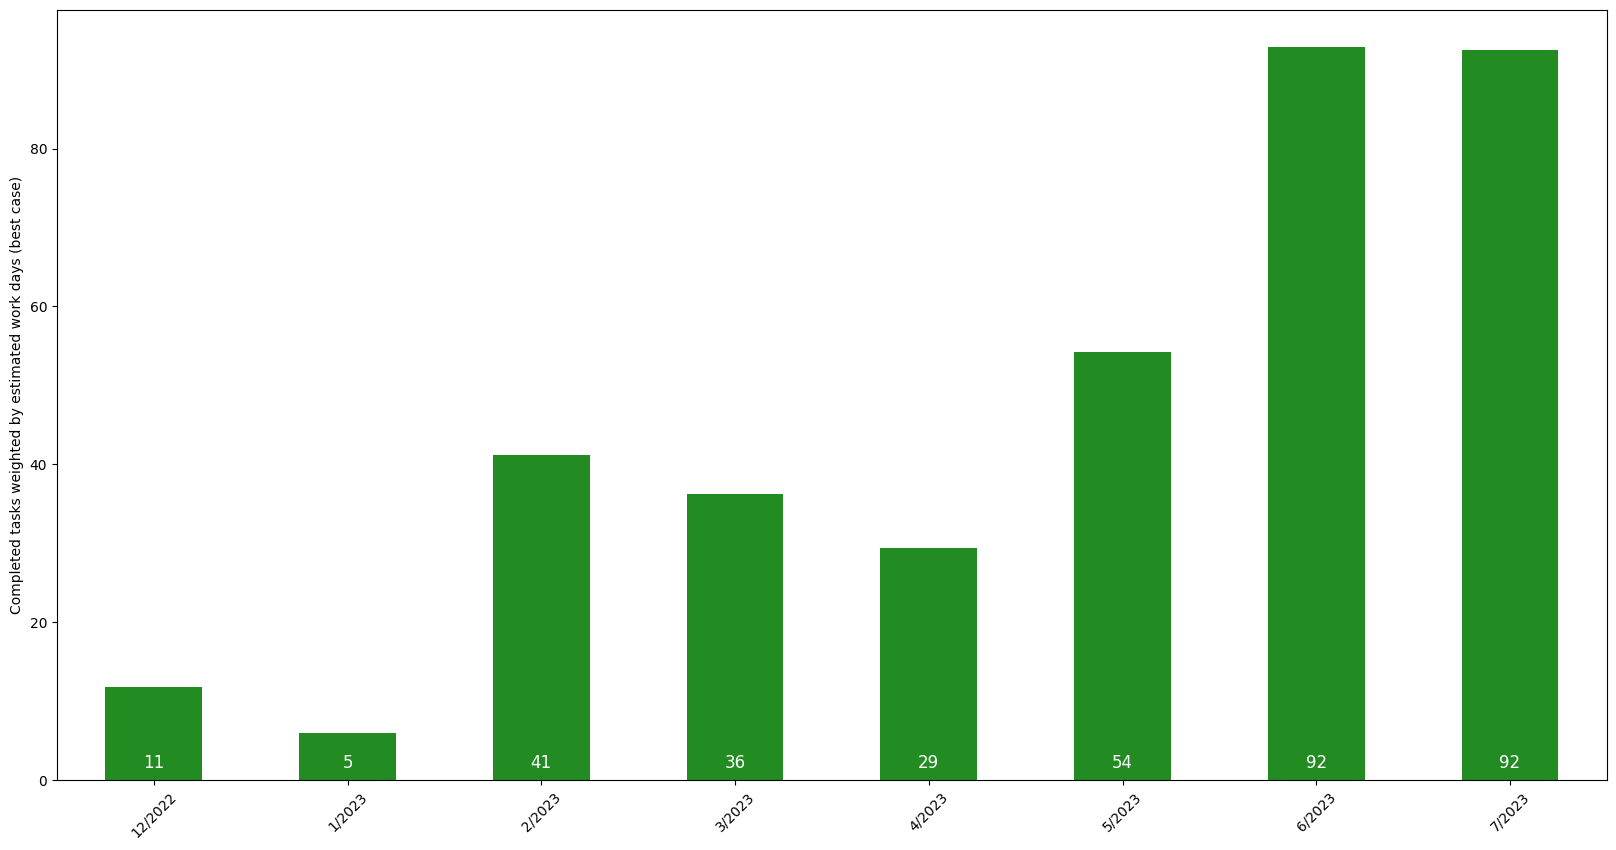

In [82]:
plot(score_per_card = lambda c: get_score(c, default=mean_score),
    title="Completed tasks weighted by estimated work days (best case)")

## Number of completed tasks weighted by estimated workdays beforehand in last 30 days

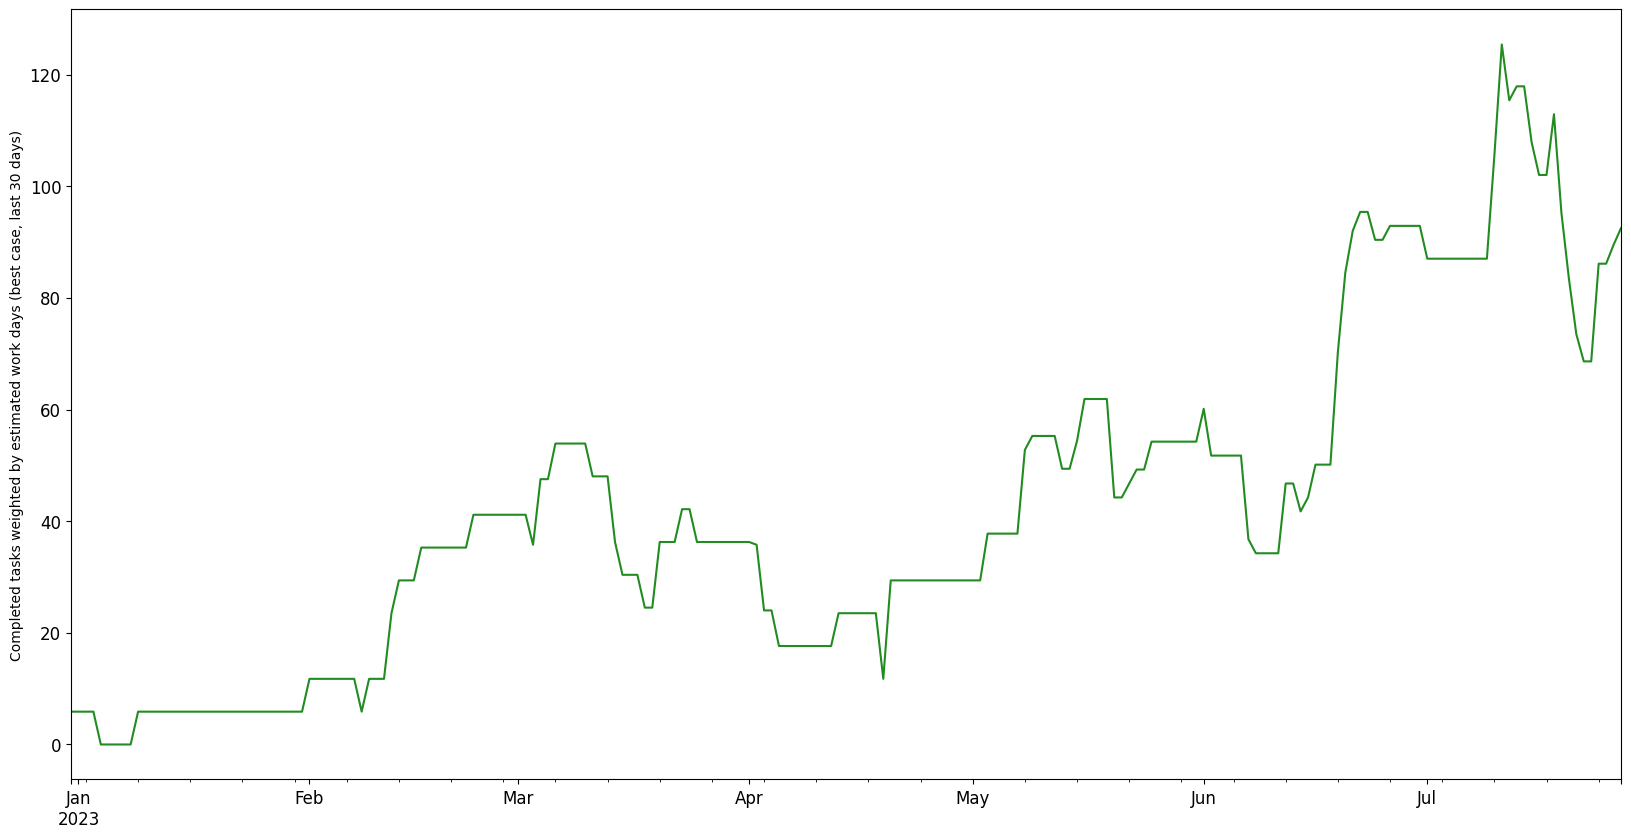

In [83]:
plot_rolling(days=30, score_per_card = lambda c: get_score(c, default=mean_score),
             title="Completed tasks weighted by estimated work days (best case, last 30 days)")

## Number of completed tasks weighted by estimated workdays beforehand in last 90 days

With ~10 FTE and ~22 workdays we would get ~660 done (not possible of course)  

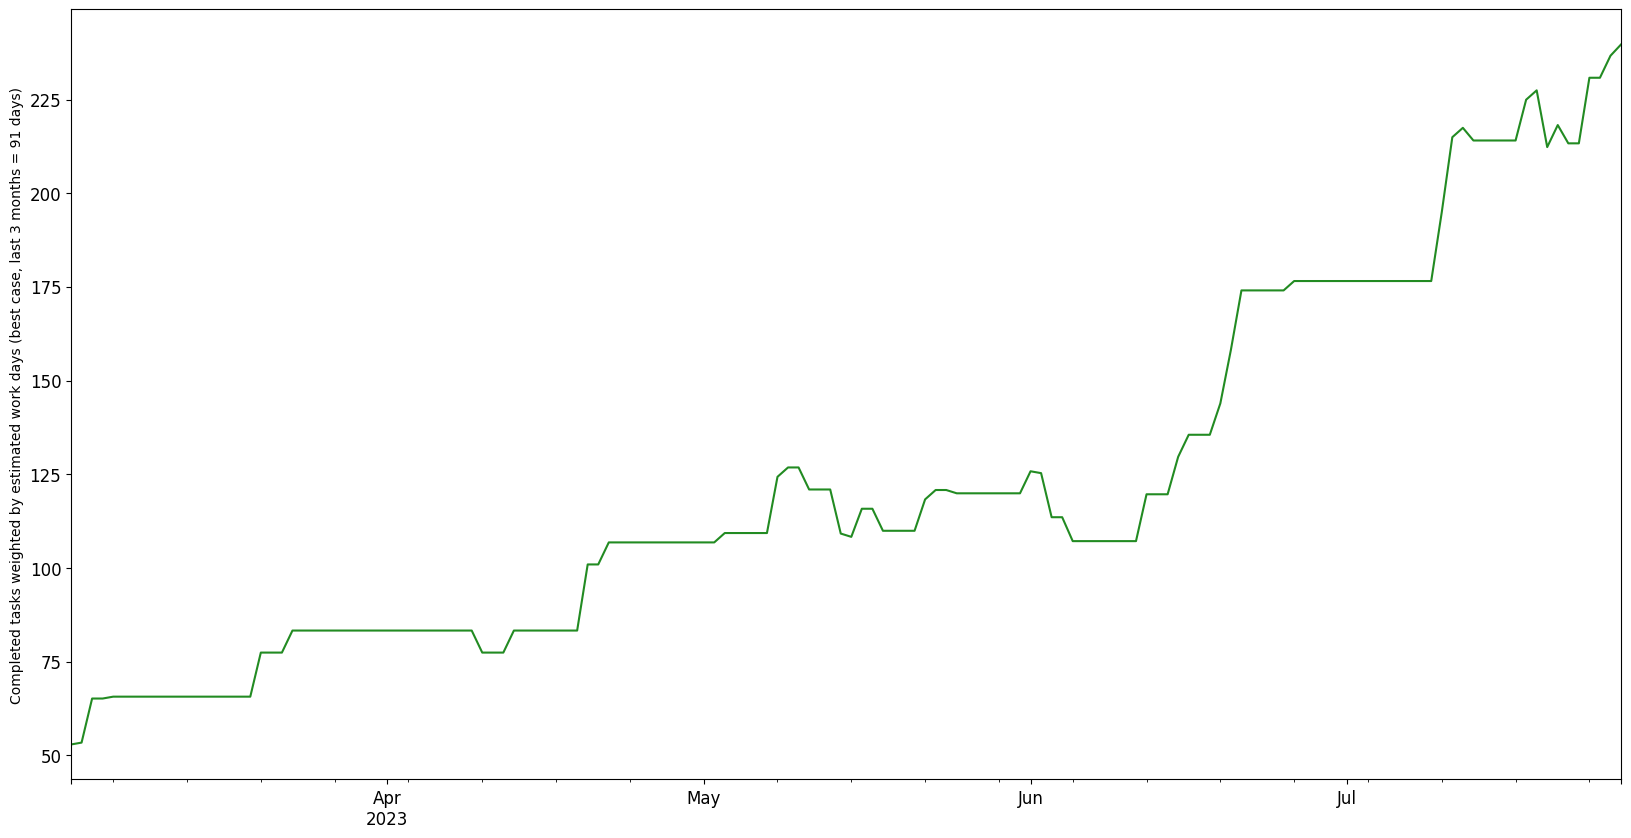

In [84]:
plot_rolling(days=91, score_per_card = lambda c: get_score(c, default=mean_score),
             title="Completed tasks weighted by estimated work days (best case, last 3 months = 91 days)")

## Mean size of cards finished in the last 30 days for each day (best case)

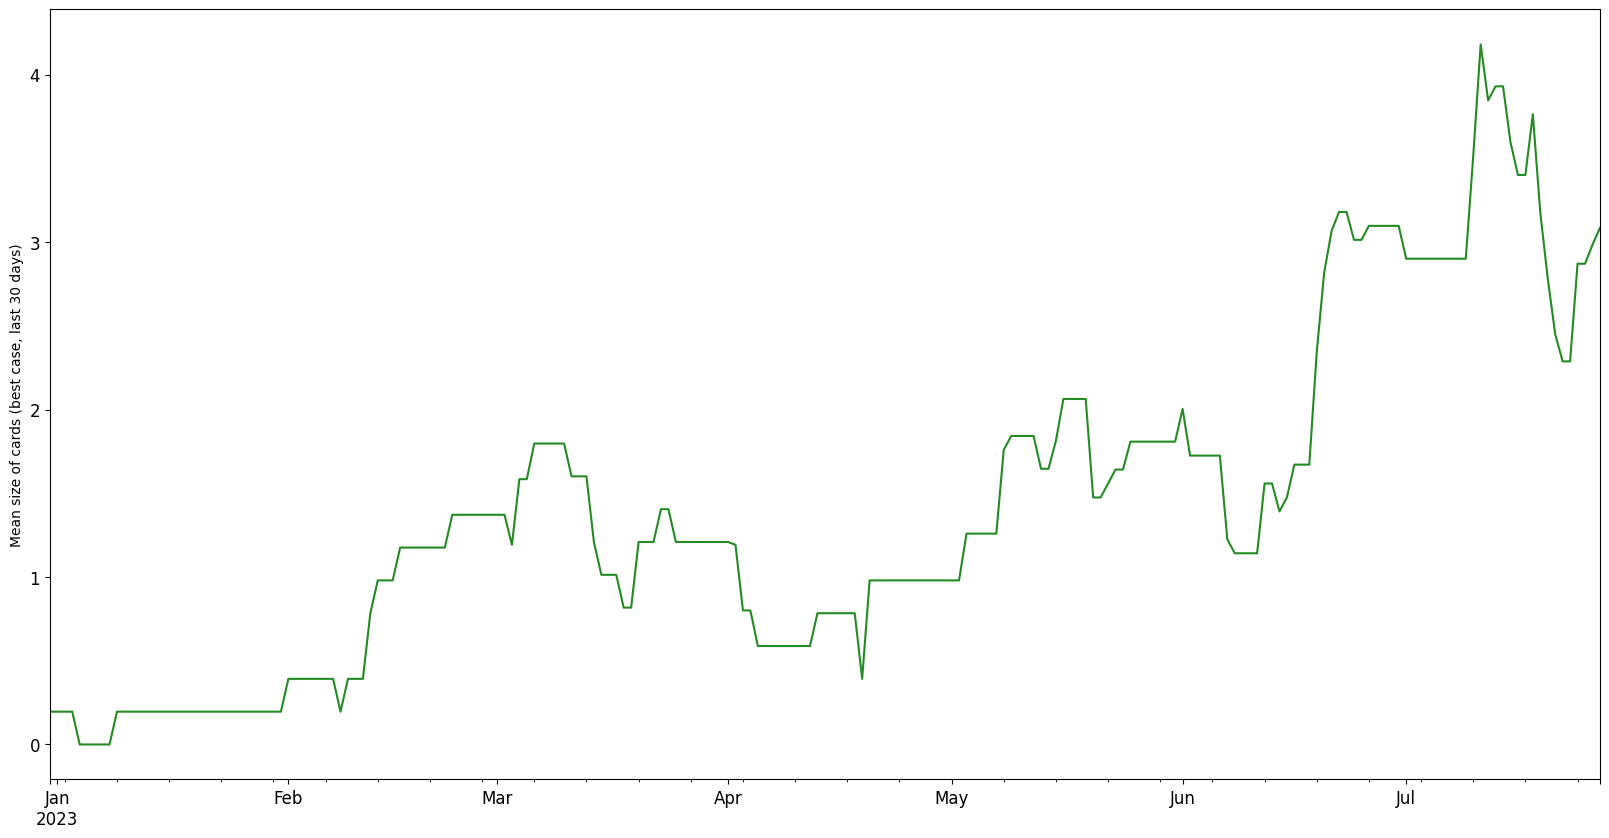

In [104]:
def plot_rolling_mean(days=30, score_per_card= lambda x: 1, title="Count of completed tasks within last 30 days"):
    data = dict((get_last_move_date(card), score_per_card(card)) for card in finished_cards)
    df = pd.DataFrame.from_dict(data, orient='index', columns=['Finished Cards'])
    df.index = pd.to_datetime(df.index)
    
    df = df.resample("1D").sum().rolling(window=days, min_periods=days).mean()
    df = df[days:]
    df.plot(figsize=(20,10), legend=False, color="forestgreen", fontsize="large")
    plt.ylabel(title)
    plt.show()

plot_rolling_mean(days=30, score_per_card = lambda c: get_score(c, default=mean_score),
             title="Mean size of cards (best case, last 30 days)")

# Completed tasks weighted by number of estimated days beforehand (worst case scenario)

We add to our cards labels which represent roughly the size of this task.
We can attribute the number of total work days needed to finish this task in a worst case scenario (people are notoriously bad in estimating the workload – so you can argue that those numbers do not reflect a
worst case scenario):

* Mini-Feature = 1 (day)
* Bug = 5 (days)
* Size `S` = 5 (days)
* Size `M` = 15 (days)
* Size `L` = 45 (days)

When we add for all cards the number of those days we get the number of estimated days for those cards in a worst case scenario. With ~10 FTE in development and ~22 workdays per month we expect to get cards with a sum of ~220 done. 

In [77]:
def get_score_bad(card, default=None):
    for label in card["labels"]:
        if label["name"] == "Mini-Feature":
            return 1
        elif label["name"] == "S":
            return 5
        elif label["name"] == "M":
            return 15
        elif label["name"] == "L":
            return 45
        elif label["name"] == "Bug":
            return 5
    return default

all_scores = [get_score_bad(card) for card in cards]
actual_scores = [s for s in all_scores if s != None]
mean_score_bad = sum(actual_scores) / len(actual_scores)

print(f"Mean of estimated days per card (best case scenario): {mean_score_bad}")

Mean of estimated days per card (best case scenario): 9.115384615384615


## Plot of this number per month

The following diagram shows this number per month. All cards without a size label get the computed mean value as weight.

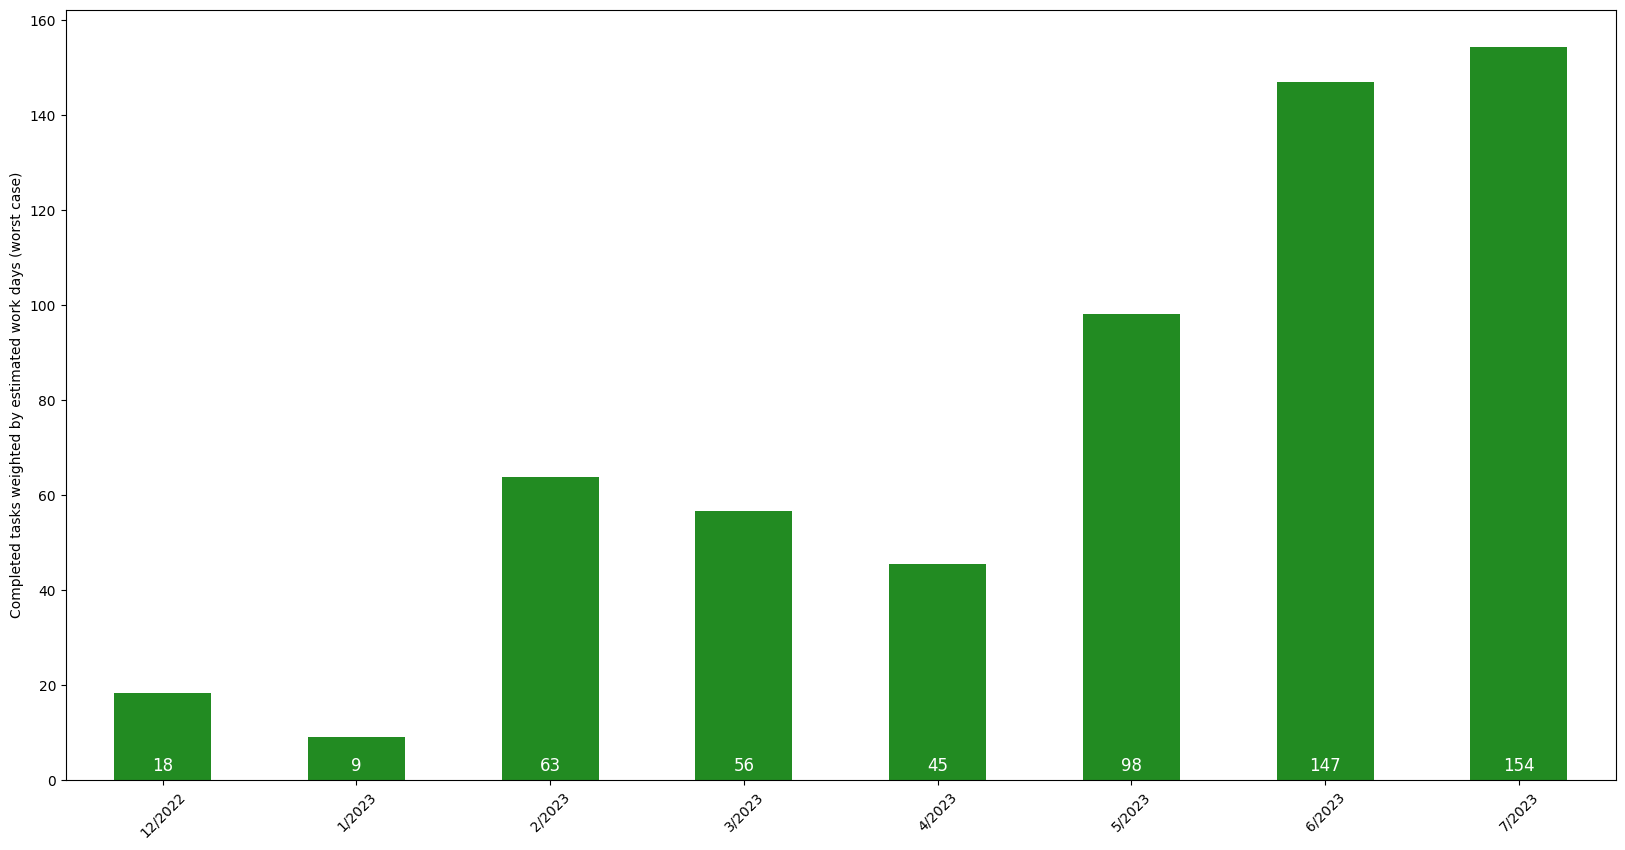

In [85]:
plot(score_per_card = lambda c: get_score_bad(c, default=mean_score_bad),
    title="Completed tasks weighted by estimated work days (worst case)")

## Number of completed tasks weighted by estimated workdays beforehand in last 30 days

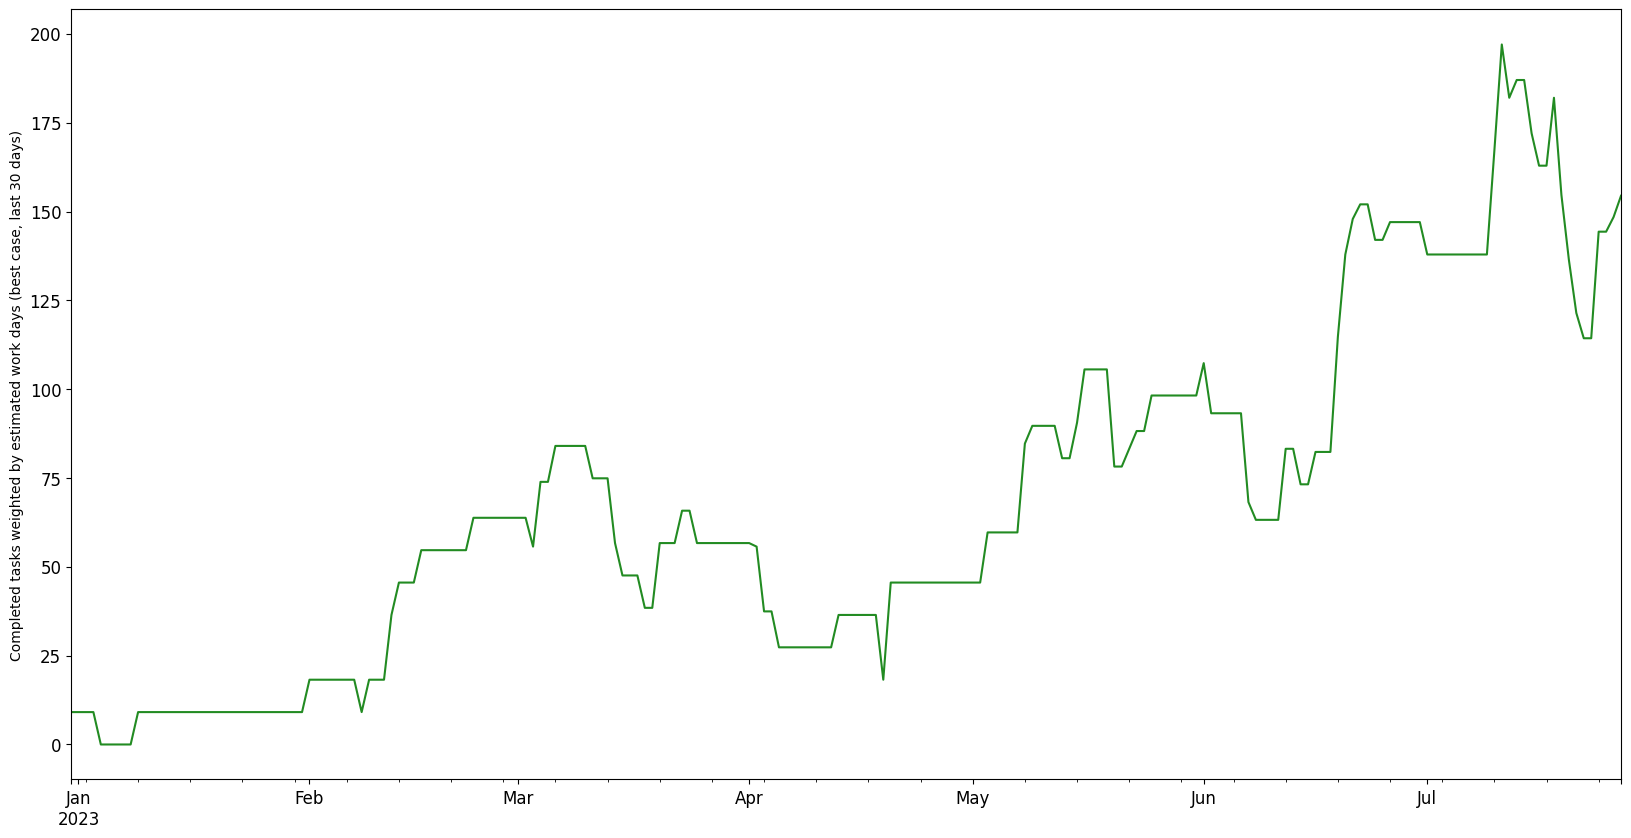

In [86]:
plot_rolling(days=30, score_per_card = lambda c: get_score_bad(c, default=mean_score_bad),
             title="Completed tasks weighted by estimated work days (best case, last 30 days)")

## Number of completed tasks weighted by estimated workdays beforehand in last 91 days

With ~10 FTE and ~22 workdays we would get ~660 done (not possible of course)  

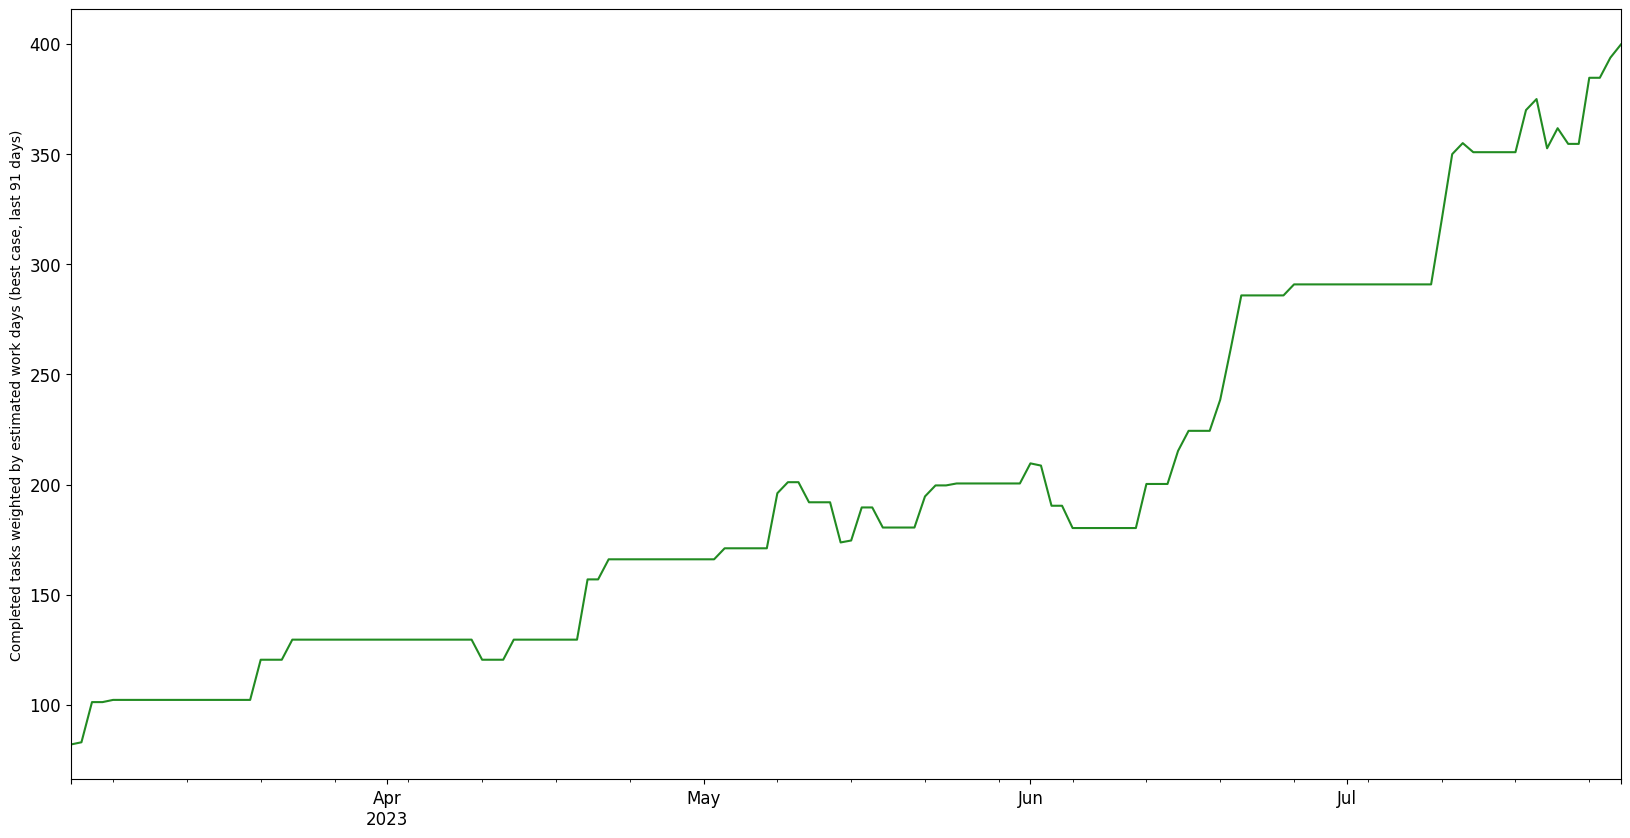

In [87]:
plot_rolling(days=91, score_per_card = lambda c: get_score_bad(c, default=mean_score_bad),
             title="Completed tasks weighted by estimated work days (best case, last 91 days)")

## Mean size of cards finished in the last 30 days for each day

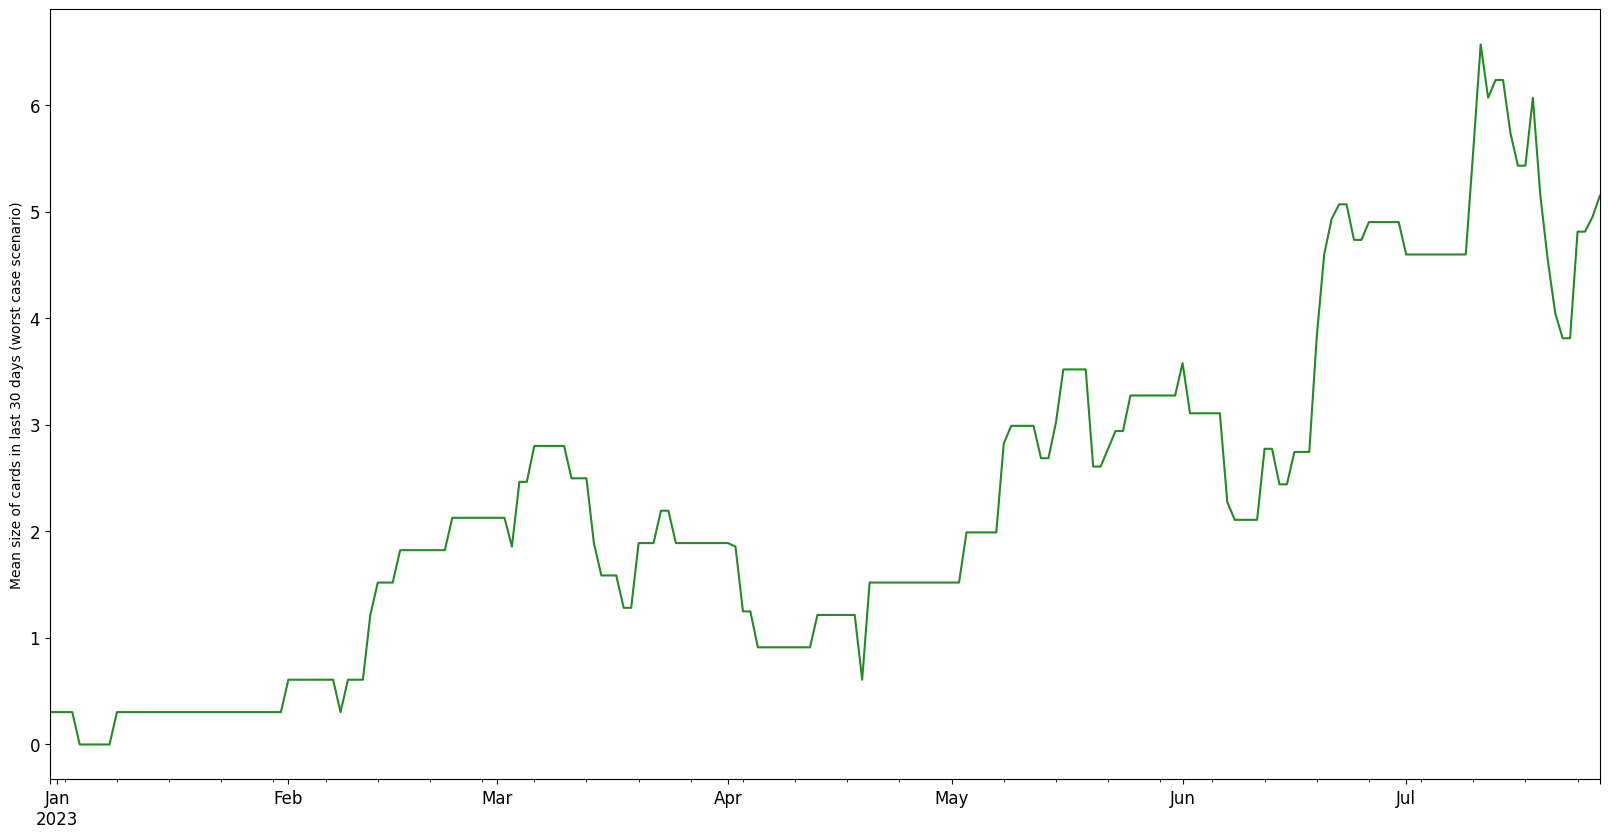

In [103]:
plot_rolling_mean(days=30, score_per_card = lambda c: get_score_bad(c, default=mean_score_bad),
             title="Mean size of cards in last 30 days (worst case scenario)")

# Cards currently in development / testing / blocked / in progress

In [75]:
from IPython.display import display, Markdown

for list_name in ["Entwicklung", "Feedback / Blocked", "Testen"]:
    display(Markdown(f'## Aktuelle Karten in "{list_name}"'))
    current_cards = [card for card in cards if card["idList"] == list_name2list_id[list_name] and not card["closed"]]
    
    for c in current_cards:
        print_card(c)

## Aktuelle Karten in "Entwicklung"

## Aktuelle Karten in "Feedback / Blocked"

## Aktuelle Karten in "Testen"

# List of finished cards

In [76]:
finished_cards = [card for card in cards if card["idList"] == list_name2list_id["Veröffentlicht (kann genutzt werden)"]]
finished_cards = sorted(finished_cards, key=get_last_move_date, reverse=True)
grouped_cards = dict()

for card in finished_cards:
    finished_date = pd.to_datetime(get_last_move_date(card))
    
    key = f"{finished_date.month}/{finished_date.year}"
    
    if key not in grouped_cards:
        grouped_cards[key] = []
    
    grouped_cards[key].append(card)

for name, cards_of_this_month in grouped_cards.items():
    display(Markdown(f"## {name}"))
    
    for card in cards_of_this_month:
        print_card(card)

## 7/2023

## 6/2023

## 5/2023

## 4/2023

## 3/2023

## 2/2023

## 1/2023

## 12/2022